# Exploration of Dimension Reduction
<span style="font-weight:bold; font-size:17pt; color:#666666;">XGBoost for feature selection</span>
<hr>

This notebook is for EDA, feature extraction, engineering and the subsequent evaluation of dimension reduction techniques.

It assumes the data (**features.csv**, the full feature set) is in a sub-directory of the **/data** folder. I've already added entries to the _.gitignore_ file so that they won't be committed to the repository. Note that this file should be updated for new versions of the data.

See the [data readme in the Gitbug repository](https://github.com/BrianDavisMath/FDA-COVID19/tree/master/data) for more details.

<hr>

In [1]:
%pylab inline
%autosave 25

import pandas as pd
import re

Populating the interactive namespace from numpy and matplotlib


Autosaving every 25 seconds


## Data location

Change this when you get a new data set.

In [2]:
data_loc = '../data/FDA-COVID19_files_v0.5/'

## Load the data from features.csv
<hr>

In [3]:
#df_features = pd.read_csv(data_loc+'features.csv')
store = pd.HDFStore(data_loc + 'features.h5')
df_features = pd.DataFrame(store['df'])
print(store)
print('rows: {:,}, columns: {:,}'.format(len(df_features), len(df_features.columns)))

<class 'pandas.io.pytables.HDFStore'>
File path: ../data/FDA-COVID19_files_v0.5/features.h5

rows: 158,806, columns: 4,521


## Experiment 1

XGBoost for features extraction.

* decompose features into dataframes with and without pid, cid and activity data etc.
* split into train and test sets <br>
* scale the training set <br>
* scale the test set with the same scaler <br>
* train the model
* tweak the parameters
* retrain, rinse and repeat

In [4]:
from sklearn.preprocessing import MinMaxScaler

# store for later
df_y = df_features['activity']
df_ids = df_features[['pid', 'cid']]

# Select only numeric columns and drop pid, cid and activity.
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
number_cols = df_features.select_dtypes(include=numerics)
number_cols = [col for col in number_cols]
number_cols.remove('activity')
number_cols.remove('cid')

print('Number of rows: {:,}'.format(len(df_features)))
print('Number of columns: {:,}'.format(len(number_cols)))

df_data = df_features[number_cols]

Number of rows: 158,806
Number of columns: 4,518


In [11]:
df_data.describe()

,GLY,ARG,GLN,GLU,ILE,ALA,THR,PRO,ASP,SER,...,Hy,TPSA(NO),TPSA(Tot),SAtot,SAacc,SAdon,Vx,VvdwMG,VvdwZAZ,PDI
count,158806.000000,158806.000000,158806.000000,158806.000000,158806.000000,158806.000000,158806.000000,158806.000000,158806.000000,158806.000000,...,158806.000000,158806.000000,158806.000000,158806.000000,158806.000000,158806.000000,158806.000000,158806.000000,158806.000000,158806.000000
mean,4.473412,4.180000,4.607689,5.139500,1.620851,5.485457,4.143611,4.300248,4.323037,4.733074,...,1.229749,106.326484,113.316604,560.234366,159.740428,77.287410,521.629118,217.159475,384.396355,0.936713
std,1.654947,1.589417,1.818258,1.341366,2.374536,2.318538,1.740363,1.832681,1.385089,1.602954,...,4.332994,138.687026,142.264344,456.248024,206.550137,126.656538,407.501592,167.008848,306.622456,0.069653
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.993000,0.000000,0.000000,55.612000,0.000000,0.000000,30.399000,15.836000,23.500000,0.481000
25%,4.329038,3.898800,4.492387,4.776265,-1.000000,5.452865,3.909093,3.983587,3.942873,4.492268,...,-0.346000,55.760000,59.670000,369.761000,81.346000,18.011000,347.575000,145.826000,254.230000,0.893000
50%,4.898937,4.592654,5.123774,5.398750,2.320979,6.278398,4.584675,4.766971,4.578271,5.116655,...,0.247000,81.780000,88.470000,488.401000,120.537000,42.683000,459.053000,191.514000,339.410000,0.946000
75%,5.293482,5.104785,5.600721,5.904883,3.820460,6.740045,5.157114,5.422568,5.105878,5.663683,...,1.383000,111.830000,120.730000,607.014000,170.453000,85.367000,577.774000,240.170000,422.190000,0.984000
max,7.079895,6.949556,7.095154,7.679257,6.507648,8.803878,7.018833,7.594929,6.932648,7.597624,...,72.454000,1832.930000,1897.070000,5723.084000,2634.121000,1920.750000,5026.910000,2063.586000,3815.530000,1.211000


In [9]:
regex = re.compile(r"\[|\]|<()", re.IGNORECASE)
df_data.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<', '(', ')'))) else col for col in df_data.columns.values]


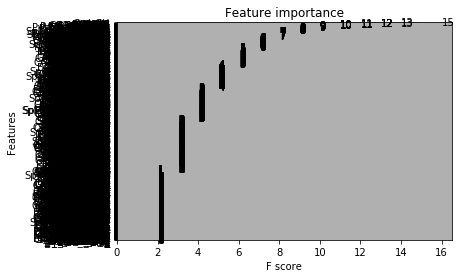

In [10]:
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
X = df_data
y = df_y
# fit model no training data
model = XGBClassifier()
model.fit(X, y)
# plot feature importance
plot_importance(model)
pyplot.show()